In [1]:
# 🟦 1. Import Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape,
                                     Bidirectional, LSTM, Dense, Lambda, Rescaling, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode

2025-05-16 03:17:10.746669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747365430.983499      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747365431.045439      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ==== CONSTANTS ====
image_height, image_width = 50, 200
batch_size = 16
dataset_path = Path("/kaggle/input/capchaimg/captcha_images_v2")

In [3]:
# ==== LOAD IMAGE PATHS AND LABELS ====
image_paths = sorted(dataset_path.glob("*.png"))
labels = [p.stem for p in image_paths]
max_length = max(len(label) for label in labels)
all_possible_characters = sorted(set("".join(labels)))

char_to_int = {ch: i for i, ch in enumerate(all_possible_characters)}
int_to_char = {i: ch for ch, i in char_to_int.items()}

In [4]:
# ==== IMAGE PREPROCESSING FUNCTION ====
def preprocess_image(path):
    image = tf.io.read_file(str(path))
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, (image_height, image_width))
    return image

In [5]:
# ==== LABEL ENCODING ====
def encode_label(label):
    return [char_to_int[c] for c in label]

In [6]:
# ==== BUILD DATASET ====
images = [preprocess_image(p) for p in image_paths]
labels_encoded = [encode_label(label) for label in labels]

I0000 00:00:1747365446.819478      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
# Padding labels to max_length
labels_padded = tf.keras.preprocessing.sequence.pad_sequences(labels_encoded, maxlen=max_length, padding='post', value=-1)

In [8]:
# Wrap as tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels_padded))
dataset = dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))

In [9]:
# Shuffle and split into 80% train, 10% val, 10% test
dataset = dataset.shuffle(buffer_size=len(images), seed=42)

num_total = len(images)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val  # đảm bảo tổng bằng tổng số ảnh

train_ds = dataset.take(num_train).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(num_train).take(num_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = dataset.skip(num_train + num_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
# ==== ĐẾM SỐ LƯỢNG ẢNH TRONG TRAIN VÀ VALIDATION ====
def count_images(dataset):
    count = 0
    for batch_images, _ in dataset:
        count += batch_images.shape[0]
    return count

num_train = count_images(train_ds)
num_val = count_images(val_ds)
num_test=count_images(test_ds)

print(f"Số lượng ảnh trong train set: {num_train}")
print(f"Số lượng ảnh trong validation set: {num_val}")
print(f"Số ảnh test: {num_test}")

Số lượng ảnh trong train set: 832
Số lượng ảnh trong validation set: 104
Số ảnh test: 104


In [11]:
# ==== MODEL ARCHITECTURE ====
input_data = Input(shape=(image_height, image_width, 1), name="input")
x = Rescaling(1./255)(input_data)
x = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]), name="transpose")(x)

x = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Reshape((image_width // 8, (image_height // 4) * 256))(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
output = Dense(len(all_possible_characters) + 1, activation="softmax")(x)

model = Model(inputs=input_data, outputs=output)
# ==== CUSTOM CTC LOSS ====
def ctc_loss(y_true, y_pred):
    input_len = tf.fill([tf.shape(y_pred)[0], 1], tf.shape(y_pred)[1])
    label_len = tf.fill([tf.shape(y_true)[0], 1], max_length)
    return ctc_batch_cost(y_true, y_pred, input_len, label_len)

model.compile(optimizer=Adam(), loss=ctc_loss)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 50, 200, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 50, 200, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transpose (Lambda)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 50, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 50, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 25, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 25, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 25, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 25, 3072)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25, 128)             │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 25, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25, 20)              │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,033,108 (3.94 MB)

 Trainable params: 1,032,212 (3.94 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
# ==== TRAINING ====
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)

Epoch 1/20


I0000 00:00:1747365462.516134      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 21.3533 - val_loss: 16.7837
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 16.2390 - val_loss: 18.6083
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 14.9504 - val_loss: 17.8573
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.1702 - val_loss: 7.3771
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.4795 - val_loss: 2.7679
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.6702 - val_loss: 1.0774
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4705 - val_loss: 0.4588
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2695 - val_loss: 0.1686
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1615 - val_loss: 0.1312
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0830 - val_loss: 0.0705
Epoch 11/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0669 - val_loss: 0.0358
Epoch 12/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0517 

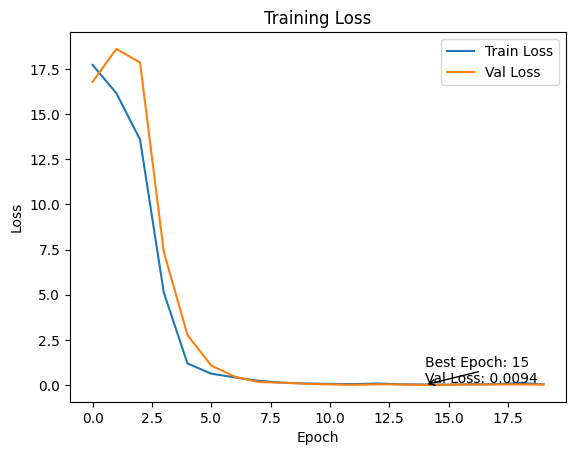

In [13]:
# ==== PLOT LOSS ====
def plot_loss(history):
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    best_epoch = np.argmin(val_loss)
    plt.annotate(f'Best Epoch: {best_epoch+1}\nVal Loss: {val_loss[best_epoch]:.4f}',
                 xy=(best_epoch, val_loss[best_epoch]), xytext=(best_epoch, val_loss[best_epoch]+0.1),
                 arrowprops=dict(arrowstyle='->'))
    plt.legend()
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

plot_loss(history)

In [14]:
# ==== EVALUATION ====
def calculate_accuracy(model, dataset, int_to_char):
    total, correct = 0, 0
    for batch_images, batch_labels in dataset:
        preds = model.predict(batch_images)
        decoded, _ = ctc_decode(preds, input_length=tf.fill([tf.shape(batch_images)[0]], tf.shape(preds)[1]), greedy=True)

        for i in range(len(batch_images)):
            # Remove -1 from padded labels
            true_label = batch_labels[i].numpy()
            true_label = [int_to_char[c] for c in true_label if c != -1]
            pred = decoded[0][i].numpy()
            pred_label = [int_to_char[c] for c in pred if c != -1]

            if ''.join(true_label) == ''.join(pred_label):
                correct += 1
            total += 1

    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Tổng số ảnh được đánh giá: {total}")
    return acc

# ==== ACCURACY TEST ====
calculate_accuracy(model, val_ds, int_to_char)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
Validation Accuracy: 0.9904
Tổng số ảnh được đánh giá: 104


0.9903846153846154

In [15]:
# ==== EVALUATION ====
def calculate_accuracy(model, dataset, int_to_char):
    total, correct = 0, 0
    for batch_images, batch_labels in dataset:
        preds = model.predict(batch_images)
        decoded, _ = ctc_decode(preds, input_length=tf.fill([tf.shape(batch_images)[0]], tf.shape(preds)[1]), greedy=True)

        for i in range(len(batch_images)):
            # Remove -1 from padded labels
            true_label = batch_labels[i].numpy()
            true_label = [int_to_char[c] for c in true_label if c != -1]
            pred = decoded[0][i].numpy()
            pred_label = [int_to_char[c] for c in pred if c != -1]

            if ''.join(true_label) == ''.join(pred_label):
                correct += 1
            total += 1

    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Tổng số ảnh được đánh giá: {total}")
    return acc

# ==== ACCURACY TEST ====
calculate_accuracy(model, val_ds, int_to_char)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Test Accuracy: 1.0000
Tổng số ảnh được đánh giá: 104


1.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


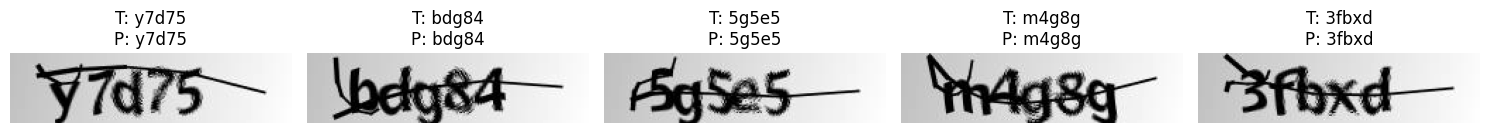

In [16]:
# ==== HIỂN THỊ 5 ẢNH VỚI NHÃN DỰ ĐOÁN TỪ VAL_DS ====

# Lấy 1 batch đầu tiên từ val_ds
for val_images, val_labels in val_ds.take(1):
    preds = model.predict(val_images)
    decoded_preds, _ = ctc_decode(preds, input_length=tf.fill([tf.shape(preds)[0]], tf.shape(preds)[1]), greedy=True)

    plt.figure(figsize=(15, 4))
    for i in range(5):
        img = val_images[i].numpy().squeeze()
        true_label = ''.join([int_to_char[c] for c in val_labels[i].numpy() if c != -1])
        pred_label = ''.join([int_to_char[c] for c in decoded_preds[0][i].numpy() if c != -1])

        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"T: {true_label}\nP: {pred_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    break